## Forecast Models

### Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates
import mplfinance as mpf
%matplotlib inline
import statsmodels.api as sm
import seaborn as sns

import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objects as go

import cufflinks as cf # Connects Plotly to Pandas
# Makes Plotly work in your Notebook
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

import requests # Get URL data
from bs4 import BeautifulSoup # Manipulate URL data
import json
from pandas import DataFrame as df

### Forecasting Intro

You are going to choose different models depending upon the data you have. We will train our model on the first group of data (Training Data : 1st 80%). Then we test the model using the last part of our data (Test Date : Last 20%). All along we are modeling using real known true results. We should forecast into the future the same length of time we test for.

### Get Our Data

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 241 entries, 2020-03-01 to 2020-10-27
Freq: D
Data columns (total 1 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   new_deaths_per_million  241 non-null    float64
dtypes: float64(1)
memory usage: 3.8 KB


DatetimeIndex(['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
               '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
               '2020-03-09', '2020-03-10',
               ...
               '2020-10-18', '2020-10-19', '2020-10-20', '2020-10-21',
               '2020-10-22', '2020-10-23', '2020-10-24', '2020-10-25',
               '2020-10-26', '2020-10-27'],
              dtype='datetime64[ns]', name='date', length=241, freq='D')

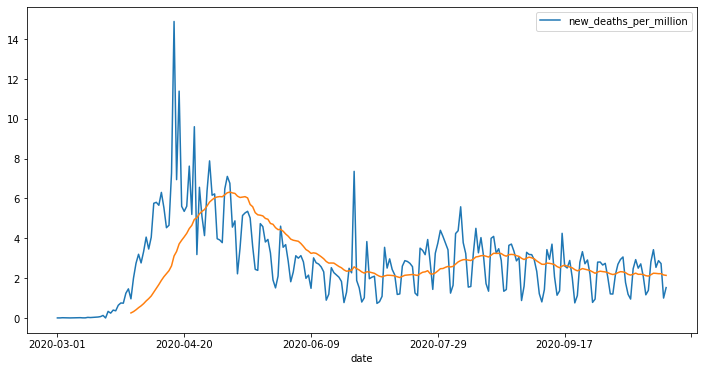

In [33]:
# Import Our World in Data CSV
# https://github.com/owid/covid-19-data/tree/master/public/data
owid_df = pd.read_csv('owid-covid-data.csv')

owid_df.columns # Show all columns

# Create Numpy array of unique countries
covid_df = owid_df.location.unique()
# Get indexes for United States
indexer = owid_df[owid_df['location']=='United States'].index
# Get dataframe location and column data for country name
covid_df = owid_df.loc[indexer, 'date':'new_deaths_per_million']
# Delete NaN values
covid_df = covid_df.dropna()
# Set date as index
covid_df.set_index('date', inplace=True)
# Remove all columns except for what I want
covid_df.drop(covid_df.columns.difference(['new_deaths_per_million']), 1, inplace=True)
covid_df.plot(figsize=(12,6))
# Plot a 30 day moving average
covid_df.rolling(window=30).mean()['new_deaths_per_million'].plot()

covid_df = covid_df.asfreq('d') # Set frequency for daily
# covid_df = covid_df.set_index('date').asfreq('d')
# Get the number of data points we have
covid_df.info() # 241 : 192 Training : 49 Test
# Separate into 2 pieces
train_df = covid_df.iloc[:192]
test_df = covid_df.iloc[191:]

covid_df.index

### Holt-Winters Model with Training Data

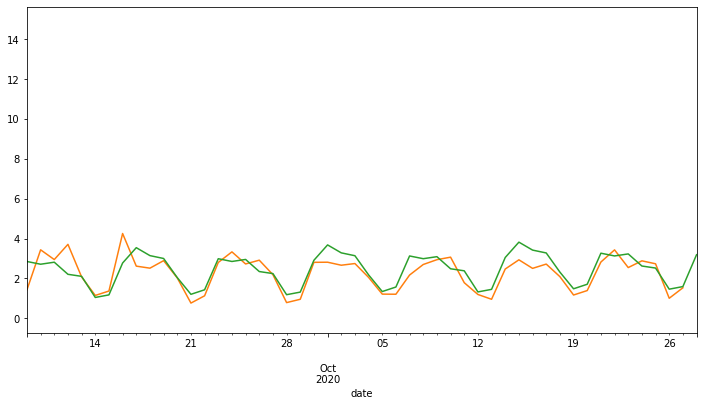

In [84]:
# The Holt - Winters Method actually models 3 aspects of the 
# time series being the average, trend and seasonality. 
# In doing so it tries to predict the future provided the 
# series is seasonal and repetitive over time.

from statsmodels.tsa.holtwinters import ExponentialSmoothing

# There is no exponential growth so I'll use additive
# I picked 14 for period because it provided the best result
fit_model = ExponentialSmoothing(train_df['new_deaths_per_million'],
                                  trend='add',
                                  seasonal='add',
                                  seasonal_periods=14).fit()
# We can now make predictions 50 days into the future
prediction = fit_model.forecast(50)
prediction

# Plot training, testing and projection data
train_df['new_deaths_per_million'].plot(figsize=(12,6))
test_df['new_deaths_per_million'].plot()
prediction.plot(xlim=['2020-09-09','2020-10-28'])


### Evaluating Predictions : Mean Absolute Error

I'll look at different options for evaluating my forecasts being Mean Absolute, Mean Squared and Root Mean Square Error.

Mean Absolute Error : Take the difference between our prediction and the true result and find the average. The negative is that a few major errors my skew the results.

\begin{equation*}
\frac{1}{n}\sum_{n}^{i=1}|y_i - \hat{y}_i|
\end{equation*}


In [90]:
def mae(y1, y2, axis=0):
    y1_np = y1.to_numpy()
    y2_np = y2.to_numpy()
    return np.mean(np.abs(y1_np - y2_np), axis=axis)

mae(test_df, prediction, None)

# We'll use the scikit-learn library
# conda install scikit-learn or
# pip install -U scikit-learn

from sklearn.metrics import mean_absolute_error, mean_squared_error

mean_absolute_error(test_df, prediction)
# test_df.mean() # How good are our results


0.9621518089453235

### Mean Squared Error

Mean Squared Error : Takes the difference like before and finds the mean, but since we square the results large errors are squared which dramatically shows those errors in the model. The negative is that the units are squared distorting the results.

\begin{equation*}
\frac{1}{n}\sum_{n}^{i=1}({y_i - \hat{y}_i})^2
\end{equation*}

In [80]:
def mse(y1, y2, axis=0):
    y1_np = y1.to_numpy()
    y2_np = y2.to_numpy()
    return ((y1_np - y2_np) ** 2).mean(axis=axis)
# axis=0 is per-column, ax=1 is per-row and ax=None is total 
mse(test_df, prediction, None)
    
mean_squared_error(test_df, prediction)


0.9722424604387213

### Root Mean Squared Error

Root Mean Squared Error : By finding the square root we return to the original unit used. When evaluating how bad an error is it depends on how large your values are. If we found our model was off by 100,000 nationally that wouldn't be as big a deal as if we were off by 100,000 in a small city.

\begin{equation*}
\sqrt{\frac{1}{n}\sum_{n}^{i=1}({y_i - \hat{y}_i})^2}
\end{equation*}

In [85]:
np.sqrt(mean_squared_error(test_df, prediction))

0.9860235597787314

### Predict the Future

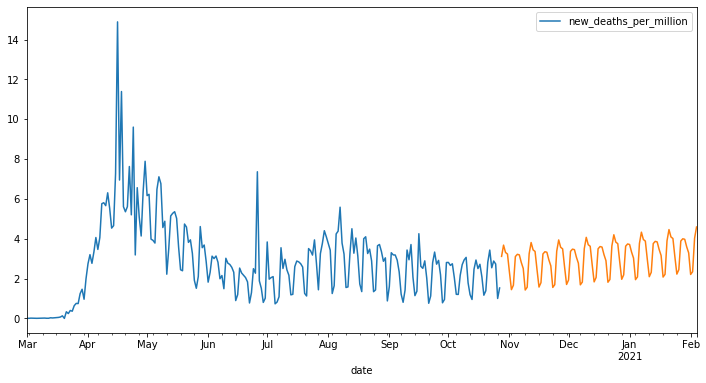

In [98]:
covid_model = ExponentialSmoothing(covid_df['new_deaths_per_million'],
                                  trend='add',
                                  seasonal='add',
                                  seasonal_periods=14).fit()
# Let's predict 100 days into the future
covid_forecast = covid_model.forecast(100)
# Print original and then our prediction
covid_df.plot(figsize=(12,6))
covid_forecast.plot()

### Stationary Datasets

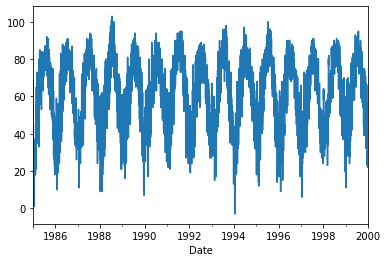

In [99]:
# We are used to working with non-stationary datasets.
# Stationary data is rather flat and the mean, variance 
# and autocorrelation structure do not change over time.
pitt_df = pd.read_csv('PittsburghWeather.csv', 
                      index_col='Date', parse_dates=True)
pitt_df['tmax'].plot(xlim=['1985-01-01','2000-01-01'])

### Auto Correlation Function

Auto Regressive Integrated Moving Average (ARIMA) based models forecast a time series based on past data and forecast errors.

The ACF and PACF provide parameters for ARIMA models.

2 groups of data that move in like ways are said to be correlated. Correlation is measured between the values of -1 (Inverse Correlation) to 0 (No Relationship) to 1 (Strongly Correlated).

With auto correlation we compare data to itself shifted a defined amount of time. For example we could shift a week and determine if last weeks performance is correlated to this week.

With auto correlation the y access is the correlation and x is the time shift amount. This way we can see how well our data is correlated over time.

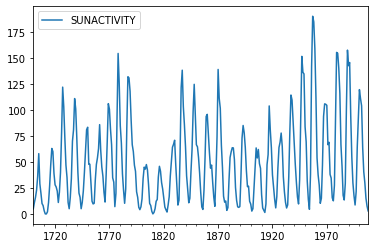

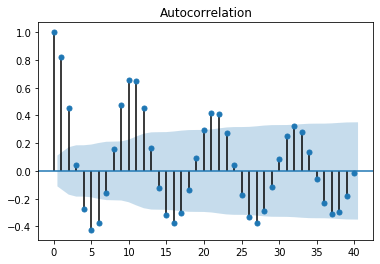

In [116]:
from statsmodels.tsa.stattools import acovf, acf
from statsmodels.graphics.tsaplots import plot_acf

# Load sunspot data
sun_df = sm.datasets.sunspots.load_pandas().data
# Set index
sun_df.index = pd.Index(sm.tsa.datetools.dates_from_range('1700', '2008'))
# Delete year column
del sun_df["YEAR"]
sun_df.plot()

acf(sun_df['SUNACTIVITY'], fft=False)

# Squeeze squeezes single column dataframes to a series
# Lag defines how much we want to shift the data
sm.graphics.tsa.plot_acf(sun_df.values.squeeze(), lags=40);


### Partial Auto Correlation Function

An auto correlation has both a direct and indirect correlation. The PAC tries to remove those indirect correlations. With it we look for the difference between our linear model and the actual results. This difference is called the residual. We then plot those residuals.

array([ 1.        ,  0.82378725, -0.69028693, -0.13025039,  0.05492352,
        0.00182287,  0.16866233,  0.22651075,  0.22199668,  0.25349103,
       -0.00138647,  0.00695794,  0.00144471,  0.00151232,  0.0594618 ,
       -0.07031568, -0.0805838 , -0.16782729, -0.09062848,  0.06411452,
       -0.00115104,  0.13364084, -0.00169989, -0.12925775, -0.04826192,
        0.01734705, -0.07697247,  0.08233459,  0.09805473, -0.10667199,
        0.02903372, -0.02221984, -0.01549459, -0.04568517,  0.02646015,
       -0.00254245, -0.05267785,  0.07981822, -0.02557282,  0.00936012,
        0.06741041])

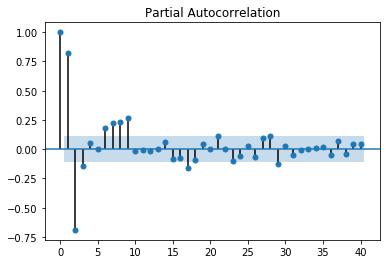

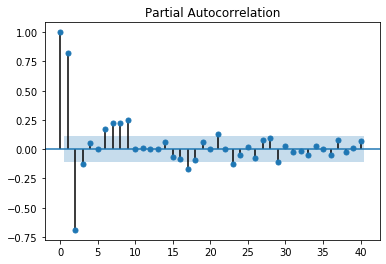

In [121]:
from statsmodels.tsa.stattools import pacf, pacf_yw, pacf_ols
from statsmodels.graphics.tsaplots import plot_pacf

# There are different ways to measure correlation and 
# different ways of measuring partial auto correlation
# Also ywm, ldunbiased, ldbiased (Levinson-Durbin recursion)
sm.graphics.tsa.plot_pacf(sun_df.values.squeeze(), lags=40,
                         method='ywunbiased');

sm.graphics.tsa.plot_pacf(sun_df.values.squeeze(), lags=40,
                         method='ols');

# Non-recursive yule_walker
pacf_yw(sun_df['SUNACTIVITY'])

# Least Squares 
pacf_ols(sun_df['SUNACTIVITY'])
